In [1]:
# import necessary packages

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.model_selection import KFold # k-fold cv
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

%precision %.7g
%matplotlib inline

## 7. Using years and IMDB user score, which clustering models (K means, Gaussian Mixture Models, Hierarchical Clustering, or DBSCAN) would create the best clusters for our dataset?

## a) 

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/tarekel96/MoviesData/master/movies.csv")
data.head()

,budget,company,country,director,genre,genre_encoded,gross,name,rating,rating_encoded,released,runtime,score,star,votes,writer,year released
0,8000000,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,0,52287414,Stand by Me,R,3,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000,Paramount Pictures,USA,John Hughes,Comedy,1,70136369,Ferris Bueller's Day Off,PG-13,2,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000,Paramount Pictures,USA,Tony Scott,Action,2,179800601,Top Gun,PG,1,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,2,85160248,Aliens,R,3,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000,Walt Disney Pictures,USA,Randal Kleiser,Adventure,0,18564613,Flight of the Navigator,PG,1,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


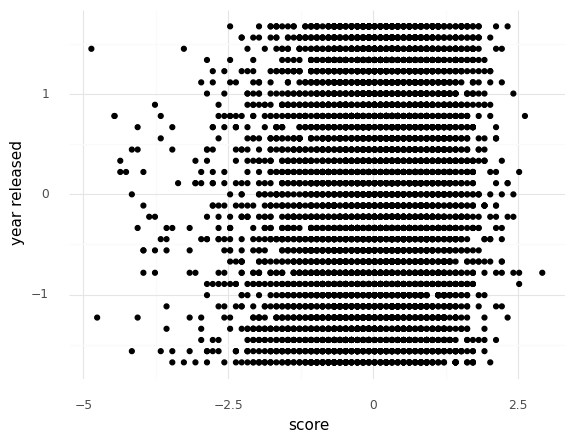

<ggplot: (8776549727476)>

In [3]:
features = ["year released", "score"]
X = data[features]

z = StandardScaler()
X[["year released", "score"]] = z.fit_transform(X)

(ggplot(X, aes("score", "year released")) + geom_point() + theme_minimal())

In [4]:
# GMM

EM = GaussianMixture(n_components = 2)
EM.fit(X[features])

GaussianMixture(n_components=2)

In [5]:
cluster = EM.predict(X[features])
cluster

array([1, 1, 1, ..., 0, 0, 0])

In [6]:
GMMnoruntimescore = silhouette_score(X[features], cluster)
print("SILHOUETTE: ", GMMnoruntimescore)

SILHOUETTE:  0.37352602092542114


HCA Silhoutte Score (3 clusters, affinity - euclidean, & linkage - ward):
0.3276350640789347


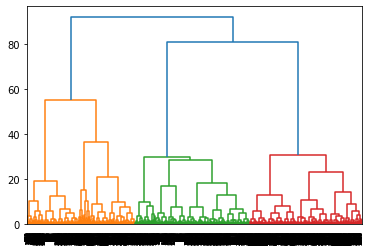

In [15]:
# HCA - 3 clusters (we'll find the optimal number of clusters later on), affinity = euclidean, & linkage = ward
HCA_Model = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean",
                             linkage = "ward")
# linkage - distance between the different clusters (method of calculating these values ie average, furthest, nearest, etc)
#  affinity - intracluster distance calculating tuning

HCA_Model.fit(X[features])
# dendro - for showing the branches
dendro = sch.dendrogram(sch.linkage(X[features], method='ward'))
# very computationally expensive

membership = HCA_Model.labels_
HCA_ward_silhouette_score = silhouette_score(X[features], membership)
print("HCA Silhoutte Score (3 clusters, affinity - euclidean, & linkage - ward):\n" + str(HCA_ward_silhouette_score))

## b)

Using years and IMDB user score, Gaussian Mixture Models (GMM) and Hierarchical Clustering (HC) would likely create the best clusters for our dataset. As shown by the first graph, in which all the data is plotted on a scatterplot, it appears that the data is very dense, so any clusters that exist within the data are likely overlapping. Given this, we eliminated both DBSCAN and K means as possible options, since both machine learning models do not perform well on data that has overlapping clusters. Instead, we used GMM and HC, which are more suited for handling overlapping clusters. In particular, GMM outperformed HC, likely because Gaussian mixture models uss probabilistic assignment, which means it assigns probabilities of belonging to each cluster to each data point. This is useful for this dataset in particular, as a Gaussian mixture model (EM) would be able to pick up the overlapping clusters using probabilistic assignment. We gauged our model's performance using their silhouette scores, which are a way for us to look at how well separated and cohesive the clusters created by the models are. GMM had a higher silhouette score of about 0.37, compared to HAC's score of about 0.33, and the higher the silhouette score, the better/more separated/more cohesive clusters the model has.

It is important to use models that create the best clusters possible in order to extrapolate accurate information from them. If we were to use DBSCAN or K means, the clusters created would likely not represent the actual clusters present in the data, which can lead to wrong assumptions being drawn from our data. Thus, by using GMM and HAC, we are more likely to draw meaningful information from the clusters that each model creates.

## c)

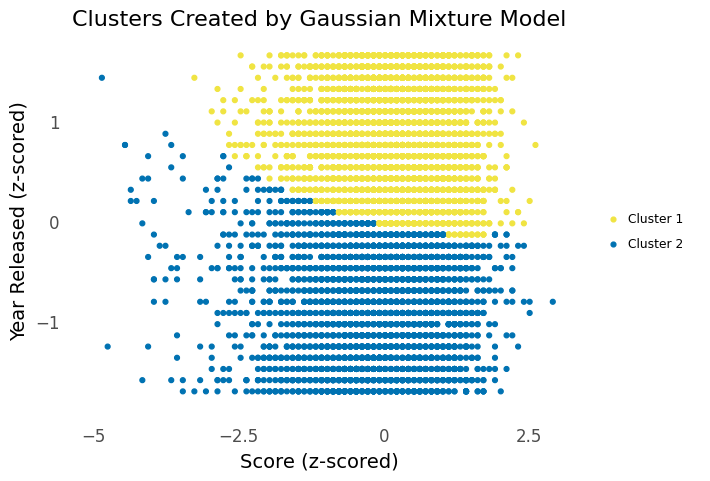

<ggplot: (8776550103926)>

In [7]:
# GMM

X["cluster"] = cluster

(ggplot(X, aes(x = "score", y = "year released", color = "factor(cluster)")) +
     geom_point() + 
     theme_minimal() +
     labs(x = "Score (z-scored)", y = "Year Released (z-scored)", color = "") +
     ggtitle("Clusters Created by Gaussian Mixture Model") +
     scale_color_manual(labels = ("Cluster 1", "Cluster 2"), values = ("#f0e442", "#0072b2")) +
     theme_minimal() + 
     theme(panel_grid_minor_x = element_blank(),
     panel_grid_minor_y = element_blank(), 
     panel_grid_major_x = element_blank(),
     panel_grid_major_y = element_blank(),
     axis_text_x = element_text(size = 12),
     axis_title_x = element_text(size = 14),
     axis_text_y = element_text(size = 12),
     axis_title_y = element_text(size = 14),
     plot_title = element_text(size = 16)))

*Caption: Graph showing the two clusters created by GMM when plotting year released versus score. GMM divided the data horizontally in the center in order to create two equally-sized clusters.*

In [8]:
HAC_scores = []
cluster_trials = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for n in cluster_trials:
    # HCA - 3 clusters, affinity = euclidean, & linkage = ward
    HAC_Model = AgglomerativeClustering(n_clusters = n, affinity = "euclidean",
                                 linkage = "ward")
    # linkage - distance between the different clusters (method of calculating these values ie average, furthest, nearest, etc)
    #  affinity - intracluster distance calculating tuning

    HAC_Model.fit(X[features])
    # dendro - for showing the branches
    # dendro = sch.dendrogram(sch.linkage(X[features], method='ward'))
    # very computationally expensive

    membership = HAC_Model.labels_
    HCA_ward_silhouette_score = silhouette_score(X[features], membership)
    cluster_dict = {
        "num_clusters": n,
        "score": HCA_ward_silhouette_score
    }
    HAC_scores.append(cluster_dict)
    print("HCA Silhoutte Score (" + str(n) 
          + " clusters):\n" 
          + str(HCA_ward_silhouette_score)
          + "\n")

HAC_scores

HCA Silhoutte Score (2 clusters):
0.30955369019164247

HCA Silhoutte Score (3 clusters):
0.3276350640789347

HCA Silhoutte Score (4 clusters):
0.3340925485827353

HCA Silhoutte Score (5 clusters):
0.32783739521912175

HCA Silhoutte Score (6 clusters):
0.2790097861404158

HCA Silhoutte Score (7 clusters):
0.25555022093770213

HCA Silhoutte Score (8 clusters):
0.2705647819387868

HCA Silhoutte Score (9 clusters):
0.2764890948152955

HCA Silhoutte Score (10 clusters):
0.27574224652822765

HCA Silhoutte Score (11 clusters):
0.2648636134951893

HCA Silhoutte Score (12 clusters):
0.26388664707234094

HCA Silhoutte Score (13 clusters):
0.26204030575302484

HCA Silhoutte Score (14 clusters):
0.2651498703191556

HCA Silhoutte Score (15 clusters):
0.25730398757135653



[{'num_clusters': 2, 'score': 0.30955369019164247},
 {'num_clusters': 3, 'score': 0.3276350640789347},
 {'num_clusters': 4, 'score': 0.3340925485827353},
 {'num_clusters': 5, 'score': 0.32783739521912175},
 {'num_clusters': 6, 'score': 0.2790097861404158},
 {'num_clusters': 7, 'score': 0.25555022093770213},
 {'num_clusters': 8, 'score': 0.2705647819387868},
 {'num_clusters': 9, 'score': 0.2764890948152955},
 {'num_clusters': 10, 'score': 0.27574224652822765},
 {'num_clusters': 11, 'score': 0.2648636134951893},
 {'num_clusters': 12, 'score': 0.26388664707234094},
 {'num_clusters': 13, 'score': 0.26204030575302484},
 {'num_clusters': 14, 'score': 0.2651498703191556},
 {'num_clusters': 15, 'score': 0.25730398757135653}]

HCA Silhoutte Score (4 clusters, affinity - euclidean, & linkage - ward):
0.3340925485827353


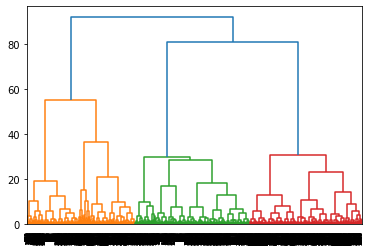

In [41]:
# HCA - 4 clusters, affinity = euclidean, & linkage = ward
HAC_Model = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean",
                             linkage = "ward")
# linkage - distance between the different clusters (method of calculating these values ie average, furthest, nearest, etc)
#  affinity - intracluster distance calculating tuning

HAC_Model.fit(X[features])
# dendro - for showing the branches
dendro = sch.dendrogram(sch.linkage(X[features], method='ward'))
# very computationally expensive

membership = HAC_Model.labels_
HCA_ward_silhouette_score = silhouette_score(X[features], membership)
print("HCA Silhoutte Score (4 clusters, affinity - euclidean, & linkage - ward):\n" + str(HCA_ward_silhouette_score))

*Caption: Dendrogram that shows the clusters created by our HAC model. Unlike GMM, which made two clusters, HAC produced three distinct clusters. It also appears that the clusters are both relatively well separated as well as cohesive, given that most of the density is towards the bottom of the graph, while the top of the graph is relatively sparse.*

## 8. Assess the performance of the best model from question 7. Additionally, how is the model performance affected when runtime is added as a variable?

## a) 

In [9]:
new_features = ["year released", "score", "runtime"]
new_X = data[new_features]

z = StandardScaler()
new_X[new_features] = z.fit_transform(new_X)

new_X.head()

,year released,score,runtime
0,-1.677164,1.719825,-0.973621
1,-1.677164,1.420743,-0.197002
2,-1.677164,0.523496,0.191308
3,-1.677164,2.018907,1.689073
4,-1.677164,0.523496,-0.918148


In [10]:
EM = GaussianMixture(n_components = 3)
EM.fit(new_X)

GaussianMixture(n_components=3)

In [11]:
cluster = EM.predict(new_X)
cluster

array([1, 1, 1, ..., 2, 2, 2])

In [12]:
GMMruntimescore = silhouette_score(new_X, cluster)
print("SILHOUETTE: ", GMMruntimescore)

SILHOUETTE:  0.28610686925562406


## b)

Based on the analyses run in part 7, the best model for this dataset is GMM. We can use the model's silhouette score to assess the model's performance. GMM had a silhouette score of about 0.37, which was greater than the approximately 0.33 silhouette score obtained by HAC. A silhouette score reflects how well separated (i.e., how far apart clusters are from each other) as well as how cohesive (i.e., how close together points in a single cluster are to each other). An ideal cluster is both well separated and cohesive, and a high silhouette score would reflect that good clusters have been obtained. Since GMM had a higher silhouette score than HAC, we can infer that GMM had the best model performance out of the two models. 

When we added in runtime as a variable, the performance of GMM decreased from about 0.37 to about 0.29. Thus, runtime decreases our model's performance by causing the clusters that it creates to be less cohesive as well as less separated.

## c) 

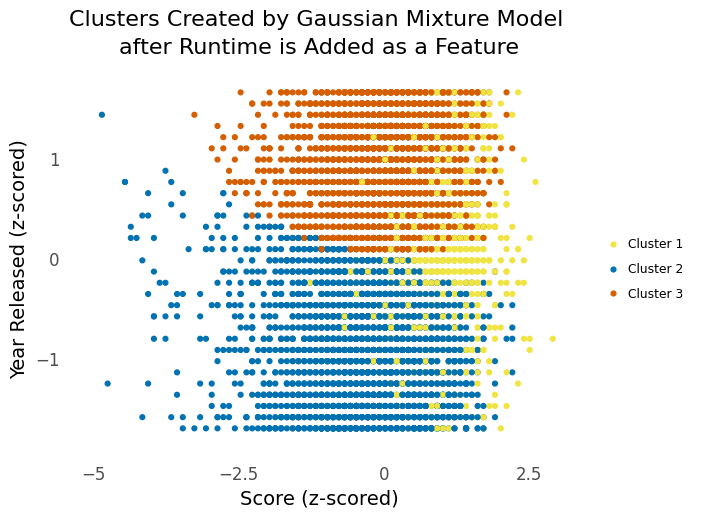

<ggplot: (8776506420387)>

In [13]:
# First ggplot (years on the x-axis and scores on the y-axis)

new_X["cluster"] = cluster

(ggplot(new_X, aes(x = "score", y = "year released", color = "factor(cluster)")) +
     geom_point() + 
     theme_minimal() +
     labs(x = "Score (z-scored)", y = "Year Released (z-scored)", color = "") +
     ggtitle("Clusters Created by Gaussian Mixture Model \nafter Runtime is Added as a Feature") +
     scale_color_manual(labels = ("Cluster 1", "Cluster 2", "Cluster 3"), values = ("#f0e442", "#0072b2", "#d55e00")) +
     theme_minimal() + 
     theme(panel_grid_minor_x = element_blank(),
     panel_grid_minor_y = element_blank(), 
     panel_grid_major_x = element_blank(),
     panel_grid_major_y = element_blank(),
     axis_text_x = element_text(size = 12),
     axis_title_x = element_text(size = 14),
     axis_text_y = element_text(size = 12),
     axis_title_y = element_text(size = 14),
     plot_title = element_text(lineheight = 1.5, size = 16)))

*Caption: Graph showing the clusters created by GMM after 'runtime' was added as a variable when plotting year released versus score. GMM divided the data into three clusters, whereas it divided the data into just two clusters when runtime was not included.*

In [14]:
# Second ggplot 
# make a new DF with just the probabilities above

group = ["Model 2 (with Runtime)","Model 1"] # column 1 of the df
score = [GMMruntimescore, GMMnoruntimescore] # column 2 of the df
myDF = {"Model": group, "Score": score} # create a dictionary for df
probDF = pd.DataFrame(myDF) # create the df using pandas
probDF.head()

,Model,Score
0,Model 2 (with Runtime),0.286107
1,Model 1,0.373526


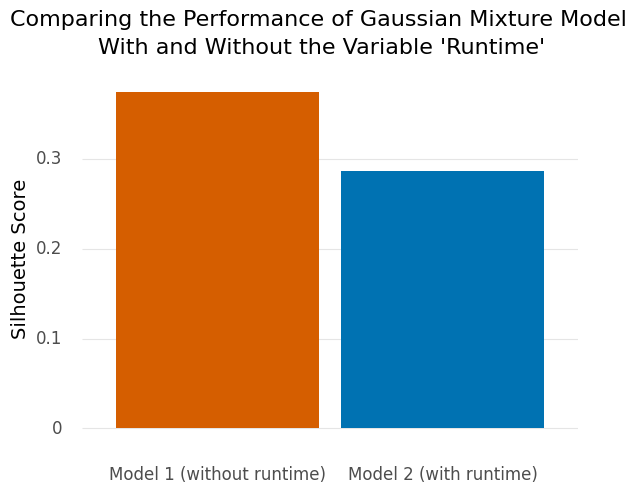

<ggplot: (8776506486673)>

In [16]:
(ggplot(probDF, aes(x = "Model", y = "Score", fill = "group")) + 
     geom_bar(stat="identity") + 
     theme_minimal() +
     labs(x = "", y = "Silhouette Score") + 
     scale_x_discrete(labels = ("Model 1 (without runtime)", "Model 2 (with runtime)")) +
     ggtitle("Comparing the Performance of Gaussian Mixture Model \nWith and Without the Variable 'Runtime'") +
     scale_fill_manual(["#d55e00", "#0072b2"]) +
     theme(panel_grid_minor_x = element_blank(),
     panel_grid_minor_y = element_blank(), 
     panel_grid_major_x = element_blank(),
     axis_text_x = element_text(size = 12),
     axis_title_x = element_text(size = 14),
     axis_text_y = element_text(size = 12),
     axis_title_y = element_text(size = 14),
     plot_title = element_text(lineheight = 1.5, size = 16),
     legend_text = element_text(size = 12),
     legend_position = "none"))

*Caption: Comparing the performance of GMM after 'runtime' was added as a variable. Model 1, or GMM without 'runtime' as a variable, performed slightly better than Model 2, or GMM with 'runtime' as a variable.*

## 9) Using the model from question 8, create three scatter plots (years vs score, years vs runtime, score vs runtime) colored by cluster assignments. Describe what each cluster in each scatter plot represents.

## a) AND c)

There is no analysis code for this section; instead, the code for this section is for generating the three ggplots.

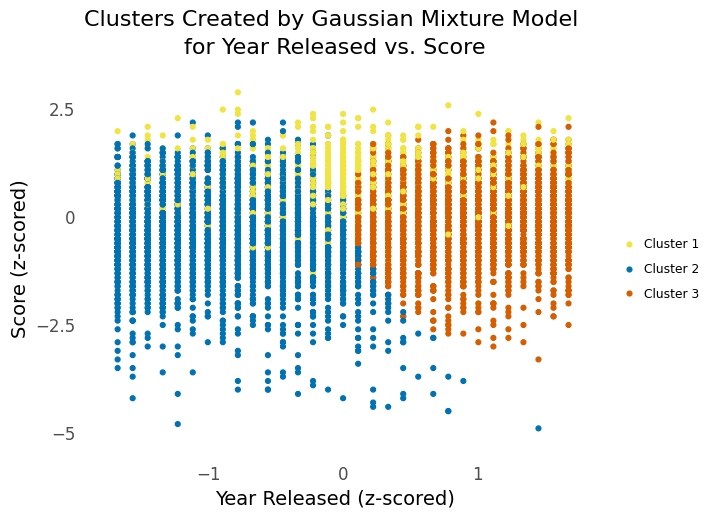

<ggplot: (8776405883266)>

In [19]:
# First ggplot

(ggplot(new_X, aes(x = "year released", y = "score", color = "factor(cluster)")) +
     geom_point() + 
     theme_minimal() +
     labs(y = "Score (z-scored)", x = "Year Released (z-scored)", color = "") +
     ggtitle("Clusters Created by Gaussian Mixture Model \nfor Year Released vs. Score") +
     scale_color_manual(labels = ("Cluster 1", "Cluster 2", "Cluster 3"), values = ("#f0e442", "#0072b2", "#d55e00")) +
     theme_minimal() + 
     theme(panel_grid_minor_x = element_blank(),
     panel_grid_minor_y = element_blank(), 
     panel_grid_major_x = element_blank(),
     panel_grid_major_y = element_blank(),
     axis_text_x = element_text(size = 12),
     axis_title_x = element_text(size = 14),
     axis_text_y = element_text(size = 12),
     axis_title_y = element_text(size = 14),
     plot_title = element_text(lineheight = 1.5, size = 16)))

*Caption: Scatterplot showing the clusters created by GMM when plotting year released versus score. GMM made three clusters, which appear to overlap to some extent.*

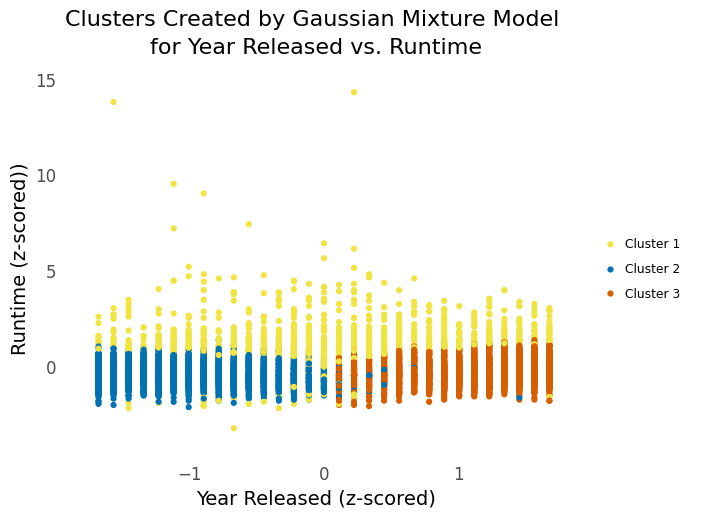

<ggplot: (8776506412029)>

In [20]:
# Second ggplot

(ggplot(new_X, aes(x = "year released", y = "runtime", color = "factor(cluster)")) +
     geom_point() + 
     theme_minimal() +
     labs(x = "Year Released (z-scored)", y = "Runtime (z-scored)", color = "") +
     ggtitle("Clusters Created by Gaussian Mixture Model \nfor Year Released vs. Runtime") +
     scale_color_manual(labels = ("Cluster 1", "Cluster 2", "Cluster 3"), values = ("#f0e442", "#0072b2", "#d55e00")) +
     theme_minimal() + 
     theme(panel_grid_minor_x = element_blank(),
     panel_grid_minor_y = element_blank(), 
     panel_grid_major_x = element_blank(),
     panel_grid_major_y = element_blank(),
     axis_text_x = element_text(size = 12),
     axis_title_x = element_text(size = 14),
     axis_text_y = element_text(size = 12),
     axis_title_y = element_text(size = 14),
     plot_title = element_text(lineheight = 1.5, size = 16)))

*Caption: Scatterplot showing the clusters created by GMM when plotting year released versus runtime. GMM made three clusters, which appear to overlap to some extent.*

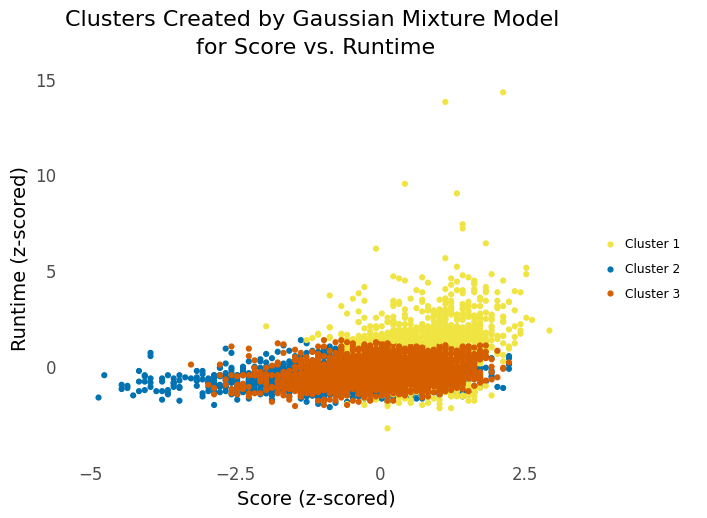

<ggplot: (8776406806363)>

In [21]:
# Third ggplot

(ggplot(new_X, aes(x = "score", y = "runtime", color = "factor(cluster)")) +
     geom_point() + 
     theme_minimal() +
     labs(x = "Score (z-scored)", y = "Runtime (z-scored)", color = "") +
     ggtitle("Clusters Created by Gaussian Mixture Model \nfor Score vs. Runtime") +
     scale_color_manual(labels = ("Cluster 1", "Cluster 2", "Cluster 3"), values = ("#f0e442", "#0072b2", "#d55e00")) +
     theme_minimal() + 
     theme(panel_grid_minor_x = element_blank(),
     panel_grid_minor_y = element_blank(), 
     panel_grid_major_x = element_blank(),
     panel_grid_major_y = element_blank(),
     axis_text_x = element_text(size = 12),
     axis_title_x = element_text(size = 14),
     axis_text_y = element_text(size = 12),
     axis_title_y = element_text(size = 14),
     plot_title = element_text(lineheight = 1.5, size = 16)))

*Caption: Scatterplot showing the clusters created by GMM when plotting year released versus runtime. GMM made three clusters, which appear to overlap to a noticeable extent.*

## 9b) 

We used the model from question 8 (i.e., GMM with year released, score, and runtime as features) to generate three scatterplots.

In the first scatterplot, GMM created three clusters -- a left blue cluster, a right red cluster, and a top yellow cluster. The left blue cluster represents movies that received a wide range of scores and came out relatively long ago, so this cluster can be labeled as "old movies". The right red cluster represents movies that also received a wide range of scores but came out relatively recently, so this cluster can be labeled as "new movies". The top yellow cluster represents movies that have a wide release date range but earned relatively good scores, so this cluster can be labeled as "good, timeless classics".

In the second scatterplot, GMM created three clusters -- a left blue cluster, a right red cluster, and a top yellow cluster. The left blue cluster represents movies with a short runtime that came out relatively long ago, so this cluster can be labeled as "old, short movies". The right red cluster represents movies that also have a short runtime but came out relatively recently, so this cluster can be labeled as "new, short movies". The top yellow cluster represents movies that have a wide release date range but are relatively long, so these can be labeled as "long movies".

In the third scatterplot, GMM created three clusters -- a bottom blue cluster, a bottom-right red cluster, and a middle-right yellow cluster. The bottom blue cluster represents movies that received a wide range of scores and have a relatively short runtime, so this cluster can be labeled as "short movies". The bottom-right red cluster represents movies that also received relatively good scores and have a relatively short runtime, so this cluster can be labeled as "good short movies". The middle-right yellow cluster represents movies that relatively received the best scores and also have a wide range of runtimes, so these can be labeled as "just good movies".